In [6]:
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [7]:
import re

def get_results(data):
    keys = ["bbox_AP", "segm_AP"]
    results = {}
    matches = re.findall(r'{.*?}', data)
    for i,match in enumerate(matches):
        match = ast.literal_eval(match)
        results[keys[i]] = match
    return results

In [8]:
import os
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator

def convert_tb_data(root_dir, sort_by=None):
    def convert_tfevent(filepath):
        return pd.DataFrame([parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )

    columns_order = ['wall_time', 'name', 'step', 'value']
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by:
        all_df = all_df.sort_values(by=sort_by)
    return all_df


### Hyperparametros

In [5]:
results = open("./../models/Glass_models/results.txt", "r")
results = results.readlines()
count = 0
results_dict = {}
for line in results:
    line = line.strip("\n")
    line_by_spaces = line.split(" ")
    if line_by_spaces[0] == "Batch":
        line_by_comas = line.split(",")
        settings = {}
        for item in line_by_comas:
            setting = item.strip(" ").split(":")
            settings[setting[0]] = float(setting[1].strip(" ")) 
        results_dict[count] = settings
    if line_by_spaces[0] == "Mean":
        results = line.strip("Mean performance of 5 folds:")
        results = ast.literal_eval(results)
        combined_results = {}
        for key in results:
            for value in results[key]:
                new_key = key + "_" + value
                combined_results[new_key] = results[key][value]
        results_dict[count] = results_dict[count] | combined_results
        count += 1

print(results_dict)
print(len(results_dict))

TypeError: unsupported operand type(s) for |: 'dict' and 'dict'

In [ ]:
print(results_dict[12])

{'Batch size': 16.0, 'Learning rate': 0.01, 'Batch size per image': 1024.0, 'bbox_AP': 47.30388536124819, 'bbox_AP50': 68.42485703590887, 'bbox_AP75': 53.82480576428884, 'bbox_APs': 38.47553783836889, 'bbox_APm': 56.48642081292407, 'bbox_APl': 57.756700428720215, 'bbox_AP-dark': 43.84400152361011, 'bbox_AP-light': 50.76376919888627, 'segm_AP': 17.317982449658864, 'segm_AP50': 50.55594623001018, 'segm_AP75': 4.319094856882285, 'segm_APs': 11.512807021344354, 'segm_APm': 33.23958924909584, 'segm_APl': 10.346534653465346, 'segm_AP-dark': 16.006923508939877, 'segm_AP-light': 18.629041390377846}


In [ ]:
df = pd.DataFrame.from_dict(results_dict, orient='index')
print(df)
print(df.shape)

    Batch size  Learning rate  Batch size per image    bbox_AP  bbox_AP50  \
0          8.0         0.0100                 128.0  43.591773  65.927237   
1          8.0         0.0100                 256.0  44.935206  67.217653   
2          8.0         0.0100                 512.0  46.684244  68.567989   
3          8.0         0.0010                 128.0  41.672199  61.979261   
4          8.0         0.0010                 256.0  43.013015  63.402731   
5          8.0         0.0010                 512.0  42.117904  61.548173   
6          8.0         0.0001                 128.0  29.794954  47.921726   
7          8.0         0.0001                 256.0  28.415329  47.210647   
8          8.0         0.0001                 512.0  20.811372  38.929418   
9         16.0         0.0100                 128.0  47.417654  69.580069   
10        16.0         0.0100                 256.0  47.135718  69.004608   
11        16.0         0.0100                 512.0  47.512305  67.934452   

In [ ]:
df_sorted = df.sort_values(by=['bbox_AP','segm_AP'], ascending=False)
df_sorted.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
11,16.0,0.01,512.0,47.512305,67.934452,54.764002,39.548815,57.688203,56.009044,43.295286,51.729324,17.986477,54.085936,4.597440,12.678896,31.522979,11.742574,16.672235,19.300720
9,16.0,0.01,128.0,47.417654,69.580069,55.111504,37.990275,58.911611,57.470876,43.563367,51.271940,17.200396,51.008179,3.885954,12.843699,33.192960,9.811881,15.273563,19.127229
12,16.0,0.01,1024.0,47.303885,68.424857,53.824806,38.475538,56.486421,57.756700,43.844002,50.763769,17.317982,50.555946,4.319095,11.512807,33.239589,10.346535,16.006924,18.629041
10,16.0,0.01,256.0,47.135718,69.004608,53.993935,38.574433,58.171946,54.149999,43.173055,51.098381,17.392221,50.265126,4.236276,12.021098,34.211788,9.069307,15.247958,19.536483
2,8.0,0.01,512.0,46.684244,68.567989,54.005698,39.241959,56.730675,52.578142,41.210948,52.157539,18.142083,51.803926,4.722612,13.227040,32.253647,11.292904,15.179671,21.104495


In [ ]:
df_sorted

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
11,16.0,0.0100,512.0,47.512305,67.934452,54.764002,39.548815,57.688203,56.009044,43.295286,51.729324,17.986477,54.085936,4.597440,12.678896,31.522979,11.742574,16.672235,19.300720
9,16.0,0.0100,128.0,47.417654,69.580069,55.111504,37.990275,58.911611,57.470876,43.563367,51.271940,17.200396,51.008179,3.885954,12.843699,33.192960,9.811881,15.273563,19.127229
12,16.0,0.0100,1024.0,47.303885,68.424857,53.824806,38.475538,56.486421,57.756700,43.844002,50.763769,17.317982,50.555946,4.319095,11.512807,33.239589,10.346535,16.006924,18.629041
10,16.0,0.0100,256.0,47.135718,69.004608,53.993935,38.574433,58.171946,54.149999,43.173055,51.098381,17.392221,50.265126,4.236276,12.021098,34.211788,9.069307,15.247958,19.536483
2,8.0,0.0100,512.0,46.684244,68.567989,54.005698,39.241959,56.730675,52.578142,41.210948,52.157539,18.142083,51.803926,4.722612,13.227040,32.253647,11.292904,15.179671,21.104495
1,8.0,0.0100,256.0,44.935206,67.217653,50.583269,36.674918,54.877146,53.536924,39.945841,49.924572,15.829881,48.267331,3.144147,11.038798,32.664304,8.089109,13.322027,18.337734
14,16.0,0.0010,256.0,44.536538,65.058956,51.462606,36.678629,55.171462,52.780881,40.651042,48.422033,14.941678,44.605959,3.284390,10.634863,32.678541,7.500000,13.545323,16.338033
0,8.0,0.0100,128.0,43.591773,65.927237,50.564414,35.955233,55.562950,51.119954,41.073403,46.110143,15.390359,46.432429,3.275657,11.558607,31.768803,8.574257,14.865415,15.915304
13,16.0,0.0010,128.0,43.166625,63.634302,49.741563,34.928201,54.097028,51.166175,38.958985,47.374265,16.091090,45.582164,4.613028,11.924241,33.152654,8.125413,15.093406,17.088774
4,8.0,0.0010,256.0,43.013015,63.402731,49.810077,34.863626,53.218026,52.740013,38.798477,47.227553,14.455119,43.611814,3.497370,10.678183,31.399797,7.894484,13.506589,15.403649


The best models are 49 and 38, however performance is realy close and the difference is not super significant. We will need to further investigate the trends to see which one is better.

In [ ]:
reduces_df = df[['Batch size', 'Learning rate', 'Batch size per image','bbox_AP', 'segm_AP']]
reduces_df.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,segm_AP
0,8.0,0.010,128.0,43.591773,15.390359
1,8.0,0.010,256.0,44.935206,15.829881
2,8.0,0.010,512.0,46.684244,18.142083
3,8.0,0.001,128.0,41.672199,14.897699
4,8.0,0.001,256.0,43.013015,14.455119


In [ ]:
grouped_bs = reduces_df.groupby('Batch size')
group = grouped_bs.get_group(8.0)
grouped_lr = group.groupby('Learning rate')
print(grouped_lr.head())

   Batch size  Learning rate  Batch size per image    bbox_AP    segm_AP
0         8.0         0.0100                 128.0  43.591773  15.390359
1         8.0         0.0100                 256.0  44.935206  15.829881
2         8.0         0.0100                 512.0  46.684244  18.142083
3         8.0         0.0010                 128.0  41.672199  14.897699
4         8.0         0.0010                 256.0  43.013015  14.455119
5         8.0         0.0010                 512.0  42.117904  13.531501
6         8.0         0.0001                 128.0  29.794954   8.522630
7         8.0         0.0001                 256.0  28.415329   8.134109
8         8.0         0.0001                 512.0  20.811372   6.969729


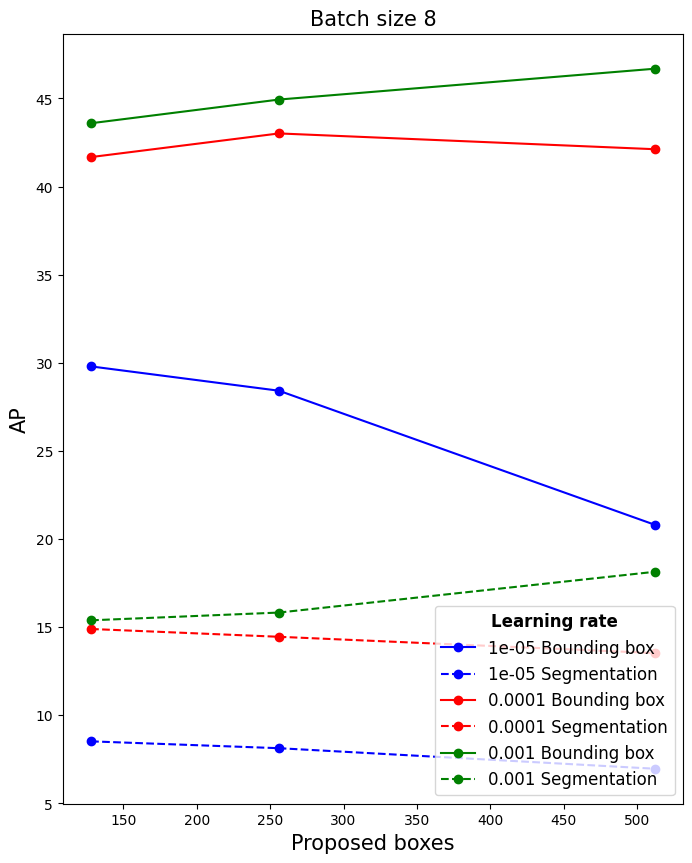

In [ ]:
# Plot for batch size 8
fig, ax = plt.subplots(figsize=(8, 10))

line_styles = ['-', '--']
labels = ['bbox_AP', 'segm_AP']
colors = ['blue', 'red', 'green']

for j, (key_lr, group_lr) in enumerate(grouped_lr):
    for k, metric in enumerate([group_lr['bbox_AP'], group_lr['segm_AP']]):
        ax.plot(group_lr['Batch size per image'], metric, marker='o', linestyle=line_styles[k], label=f'{key_lr} {labels[k]}', color=colors[j])
ax.set_title('Batch size 8', fontsize=15)
ax.set_xlabel('Proposed boxes', fontsize=15)
ax.set_ylabel('AP', fontsize=15)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, ['1e-05 Bounding box', '1e-05 Segmentation', '0.0001 Bounding box', '0.0001 Segmentation', '0.001 Bounding box', '0.001 Segmentation'], loc='lower right', title='Learning rate', fontsize='large')
legend.get_title().set_fontsize('large')
legend.get_title().set_fontweight('bold')

plt.show()




In [ ]:
group = grouped_bs.get_group(16.0)
grouped_lr = group.groupby('Learning rate')
print(grouped_lr.head())

    Batch size  Learning rate  Batch size per image    bbox_AP    segm_AP
9         16.0         0.0100                 128.0  47.417654  17.200396
10        16.0         0.0100                 256.0  47.135718  17.392221
11        16.0         0.0100                 512.0  47.512305  17.986477
12        16.0         0.0100                1024.0  47.303885  17.317982
13        16.0         0.0010                 128.0  43.166625  16.091090
14        16.0         0.0010                 256.0  44.536538  14.941678
15        16.0         0.0010                 512.0  42.449129  14.977607
16        16.0         0.0010                1024.0  38.748870  13.187574
17        16.0         0.0001                 128.0  30.321920   8.955534
18        16.0         0.0001                 256.0  27.839386   7.653886
19        16.0         0.0001                 512.0  21.032390   7.241761
20        16.0         0.0001                1024.0  19.248581   6.677746


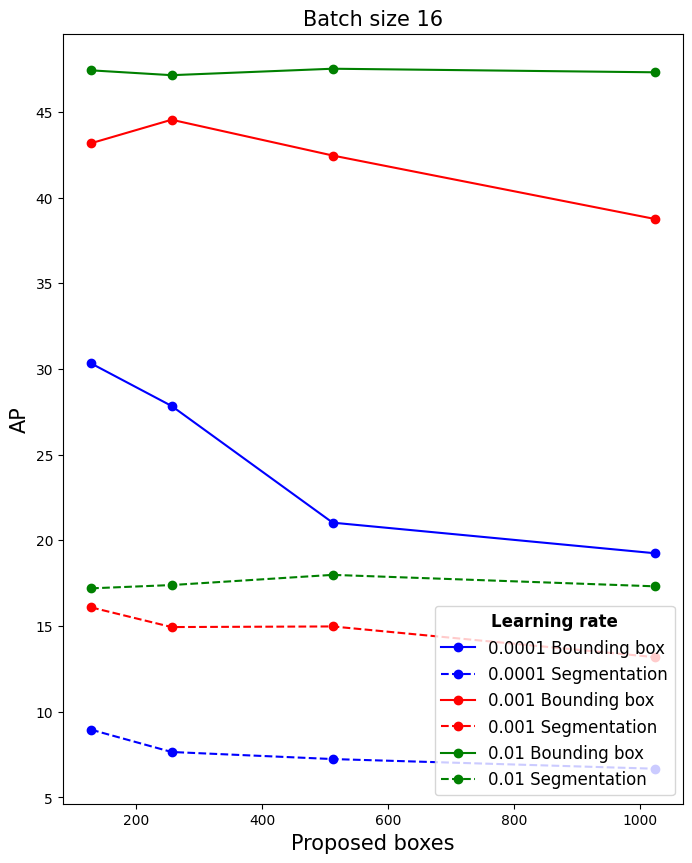

In [ ]:
# Plot for batch size 16
fig, ax = plt.subplots(figsize=(8, 10))


line_styles = ['-', '--']
labels = ['bbox_AP', 'segm_AP']
colors = ['blue', 'red', 'green']

for j, (key_lr, group_lr) in enumerate(grouped_lr):
    for k, metric in enumerate([group_lr['bbox_AP'], group_lr['segm_AP']]):
        ax.plot(group_lr['Batch size per image'], metric, marker='o', linestyle=line_styles[k], label=f'{key_lr} {labels[k]}', color=colors[j])
ax.set_title('Batch size 16', fontsize=15)
ax.set_xlabel('Proposed boxes', fontsize=15)
ax.set_ylabel('AP', fontsize=15)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, ['0.0001 Bounding box', '0.0001 Segmentation', '0.001 Bounding box', '0.001 Segmentation', '0.01 Bounding box', '0.01 Segmentation'], loc='lower right', title='Learning rate', fontsize='large')
legend.get_title().set_fontsize('large')
legend.get_title().set_fontweight('bold')

plt.show()

The most relevant graphs are the ones with batch size of 6,8,10 as they yield the best results, more particularly 8 and 10. From 8 and 10 the same tendeny related to tuhe learning reate apear, as it shows that the best learning rate is 0.001. Within this lr, there are same similarities within the bspi, as bs=8.0 the best bs is 256 and higher value gets way worse results, and lower also worst but less significant. For bs=10.0 the best bs is 128, and the same trend is observed. So the ideal bspi looks between 128 and 256.

### Folds

In [9]:
results = open("./../models/Glass_models/results.txt", "r")
results = results.readlines()
count = 0
data_dict = {}

for i, line in enumerate(results):
    line = line.strip("\n")
    if line == str(count):
        data_list = results[i+3:i+8]
        data_len = len(data_list)
        data = [d.split("OrderedDict")[1] for d in data_list]
        results_to_dict = [get_results(d) for d in data]
        fold_dict = {}
        for i, r in enumerate(results_to_dict):
            fold_dict[i] = r
        data_dict[count] = fold_dict
        count += 1

print(data_dict)

{0: {0: {'bbox_AP': {'AP': 38.36160836637298, 'AP50': 62.79320568211541, 'AP75': 41.294693847527654, 'APs': 33.92194125659601, 'APm': 52.21178556957964, 'APl': 41.782747865772485, 'AP-dark': 38.183289675642996, 'AP-light': 38.53992705710297}, 'segm_AP': {'AP': 15.26835309953306, 'AP50': 43.9055045902179, 'AP75': 5.025430319368716, 'APs': 12.84409539838552, 'APm': 32.70172610771327, 'APl': 10.099009900990099, 'AP-dark': 11.276970302824298, 'AP-light': 19.25973589624182}}, 1: {'bbox_AP': {'AP': 49.49465463828, 'AP50': 70.24002565245839, 'AP75': 60.29494899828747, 'APs': 39.02655642609197, 'APm': 60.53329922229147, 'APl': 63.51679108490488, 'AP-dark': 46.356603906480515, 'AP-light': 52.63270537007947}, 'segm_AP': {'AP': 18.21021239986325, 'AP50': 52.51494079284898, 'AP75': 2.294710123684909, 'APs': 13.099721702778721, 'APm': 32.43378021985333, 'APl': 11.287128712871288, 'AP-dark': 20.616764639179394, 'AP-light': 15.8036601605471}}, 2: {'bbox_AP': {'AP': 41.07479039081262, 'AP50': 62.14953

In [10]:
data_dict_unified = {}
for count in data_dict:
    for fold in data_dict[count]:
        for value in data_dict[count][fold]:
            for metric in data_dict[count][fold][value]:
                new_key = value + "_" + metric
                if count not in data_dict_unified:
                    data_dict_unified[count] = {}
                if fold not in data_dict_unified[count]:
                    data_dict_unified[count][fold] = {}
                data_dict_unified[count][fold][new_key] = data_dict[count][fold][value][metric]

print(data_dict_unified)

{0: {0: {'bbox_AP_AP': 38.36160836637298, 'bbox_AP_AP50': 62.79320568211541, 'bbox_AP_AP75': 41.294693847527654, 'bbox_AP_APs': 33.92194125659601, 'bbox_AP_APm': 52.21178556957964, 'bbox_AP_APl': 41.782747865772485, 'bbox_AP_AP-dark': 38.183289675642996, 'bbox_AP_AP-light': 38.53992705710297, 'segm_AP_AP': 15.26835309953306, 'segm_AP_AP50': 43.9055045902179, 'segm_AP_AP75': 5.025430319368716, 'segm_AP_APs': 12.84409539838552, 'segm_AP_APm': 32.70172610771327, 'segm_AP_APl': 10.099009900990099, 'segm_AP_AP-dark': 11.276970302824298, 'segm_AP_AP-light': 19.25973589624182}, 1: {'bbox_AP_AP': 49.49465463828, 'bbox_AP_AP50': 70.24002565245839, 'bbox_AP_AP75': 60.29494899828747, 'bbox_AP_APs': 39.02655642609197, 'bbox_AP_APm': 60.53329922229147, 'bbox_AP_APl': 63.51679108490488, 'bbox_AP_AP-dark': 46.356603906480515, 'bbox_AP_AP-light': 52.63270537007947, 'segm_AP_AP': 18.21021239986325, 'segm_AP_AP50': 52.51494079284898, 'segm_AP_AP75': 2.294710123684909, 'segm_AP_APs': 13.099721702778721, 

In [11]:
data_df = pd.concat({(i,j): pd.DataFrame(data_dict_unified[i][j], index=[0]) for i in data_dict_unified.keys() 
                for j in data_dict_unified[i].keys()}, axis=0)

# Reset the index
data_df.reset_index(inplace=True)

# Rename the columns
data_df.columns = ['OuterKey', 'InnerKey'] + list(data_df.columns[2:])
data_df = data_df.drop(columns=["level_2"])

# Print the DataFrame
data_df.head()

,OuterKey,InnerKey,bbox_AP_AP,bbox_AP_AP50,bbox_AP_AP75,bbox_AP_APs,bbox_AP_APm,bbox_AP_APl,bbox_AP_AP-dark,bbox_AP_AP-light,segm_AP_AP,segm_AP_AP50,segm_AP_AP75,segm_AP_APs,segm_AP_APm,segm_AP_APl,segm_AP_AP-dark,segm_AP_AP-light
0,0,0,38.361608,62.793206,41.294694,33.921941,52.211786,41.782748,38.183290,38.539927,15.268353,43.905505,5.025430,12.844095,32.701726,10.099010,11.276970,19.259736
1,0,1,49.494655,70.240026,60.294949,39.026556,60.533299,63.516791,46.356604,52.632705,18.210212,52.514941,2.294710,13.099722,32.433780,11.287129,20.616765,15.803660
2,0,2,41.074790,62.149534,47.309632,34.704747,50.737908,42.144889,34.066740,48.082840,14.291103,44.107804,3.524922,9.323425,30.314711,5.396040,13.576417,15.005789
3,0,3,47.702759,71.187196,58.354706,36.267465,59.431132,59.579625,47.622988,47.782531,17.948424,51.220519,4.301998,13.206969,34.684475,9.405941,18.138423,17.758425
4,0,4,41.325052,63.266224,45.568087,35.855456,54.900624,48.575716,39.137393,43.512710,11.233704,40.413377,1.231223,9.318826,28.709323,6.683168,10.718499,11.748908


In [12]:
data_df_bbox = data_df[['OuterKey', 'bbox_AP_AP']]
data_df_segm = data_df[['OuterKey', 'segm_AP_AP']]

In [13]:
grouped_data_bbox_df = data_df_bbox.groupby('OuterKey').describe()
grouped_data_segm_df = data_df_segm.groupby('OuterKey').describe()
grouped_data_bbox_df.head()
print(grouped_data_segm_df.shape)


(18, 8)


In [14]:
grouped_data_segm_df.head()

segm_AP_AP                                                        \
              count       mean       std        min        25%        50%   
OuterKey                                                                    
0               5.0  15.390359  2.872120  11.233704  14.291103  15.268353   
1               5.0  15.829881  1.622071  13.105083  15.677423  16.337149   
2               5.0  18.142083  3.444697  12.351533  18.281875  19.029283   
3               5.0  14.897699  2.224738  12.576405  13.176797  14.598387   
4               5.0  14.455119  1.700389  12.231576  13.336069  14.588213   

                                
                75%        max  
OuterKey                        
0         17.948424  18.210212  
1         16.940869  17.088879  
2         19.580239  21.467487  
3         16.085088  18.051816  
4         15.743075  16.376664

Text(0, 0.5, 'Value')

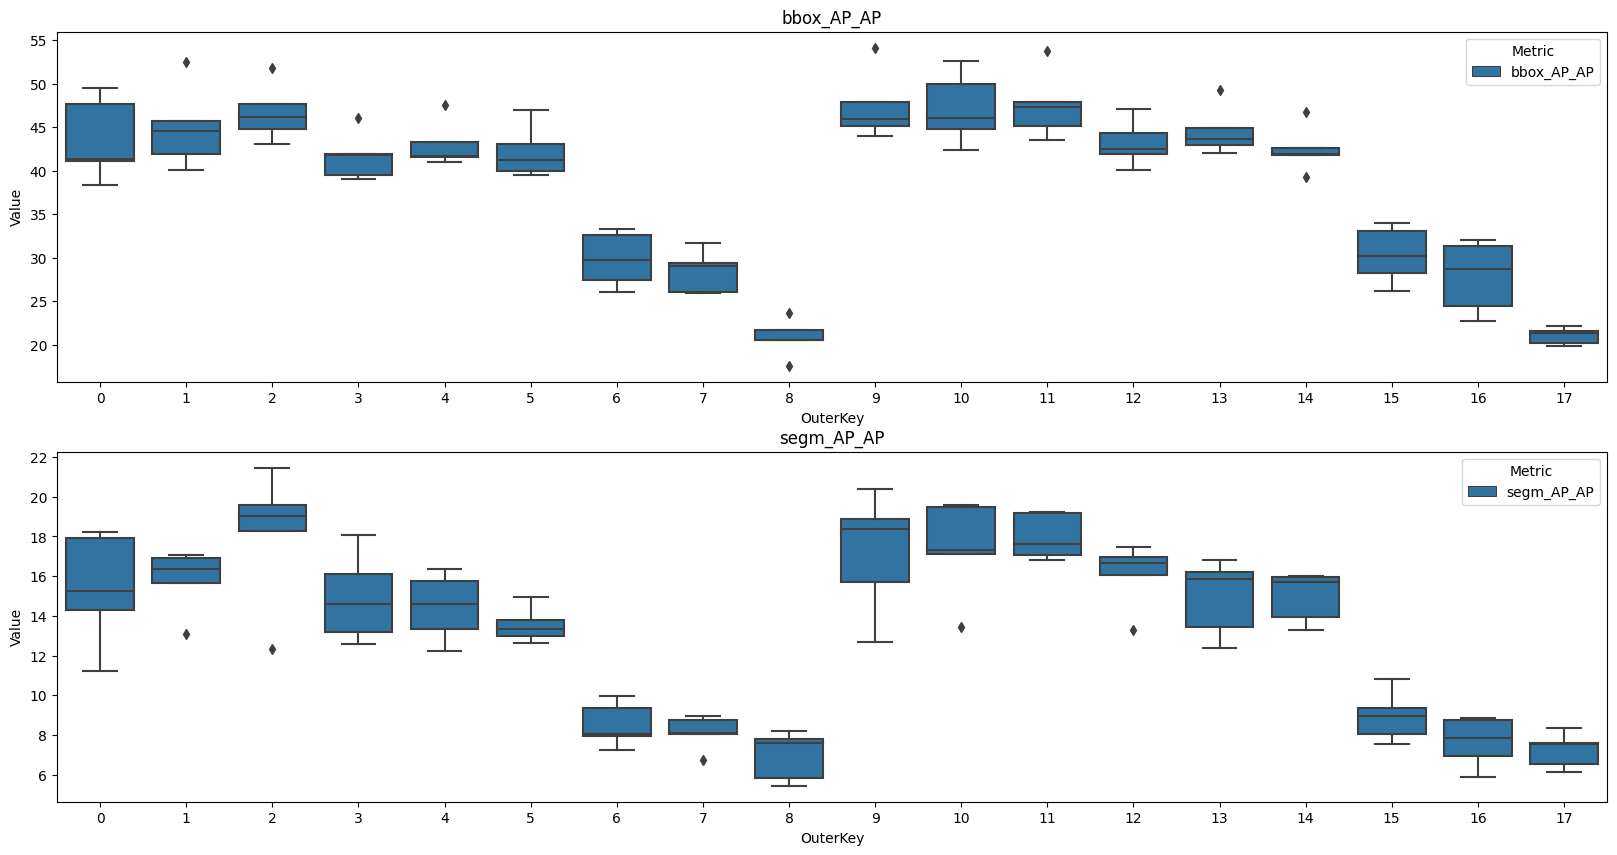

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

melted_bbox_df = data_df_bbox.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_bbox_df, hue='Metric', ax=ax[0])
ax[0].set_title('bbox_AP_AP')
ax[0].set_xlabel('OuterKey')
ax[0].set_ylabel('Value')

melted_segm_df = data_df_segm.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_segm_df, hue='Metric', ax=ax[1])
ax[1].set_title('segm_AP_AP')
ax[1].set_xlabel('OuterKey')
ax[1].set_ylabel('Value')

In [16]:
# Save a new df for sections of 12 rows of oute key of grouped_bbox_data_bbox_df
grouped_bbox_data_0_11 = grouped_data_bbox_df[0:9]
grouped_bbox_data_12_23 = grouped_data_bbox_df[9:18]
print(grouped_bbox_data_0_11.shape, grouped_bbox_data_12_23.shape)
grouped_bbox_data_0_11.head()

(9, 8) (9, 8)


bbox_AP_AP                                                        \
              count       mean       std        min        25%        50%   
OuterKey                                                                    
0               5.0  43.591773  4.758468  38.361608  41.074790  41.325052   
1               5.0  44.935206  4.774366  40.059704  41.886745  44.517976   
2               5.0  46.684244  3.338272  43.023189  44.808670  46.152721   
3               5.0  41.672199  2.768486  39.084258  39.523429  41.786456   
4               5.0  43.013015  2.666772  40.990213  41.507773  41.723947   

                                
                75%        max  
OuterKey                        
0         47.702759  49.494655  
1         45.703392  52.508215  
2         47.601555  51.835084  
3         41.904143  46.062707  
4         43.320948  47.522193

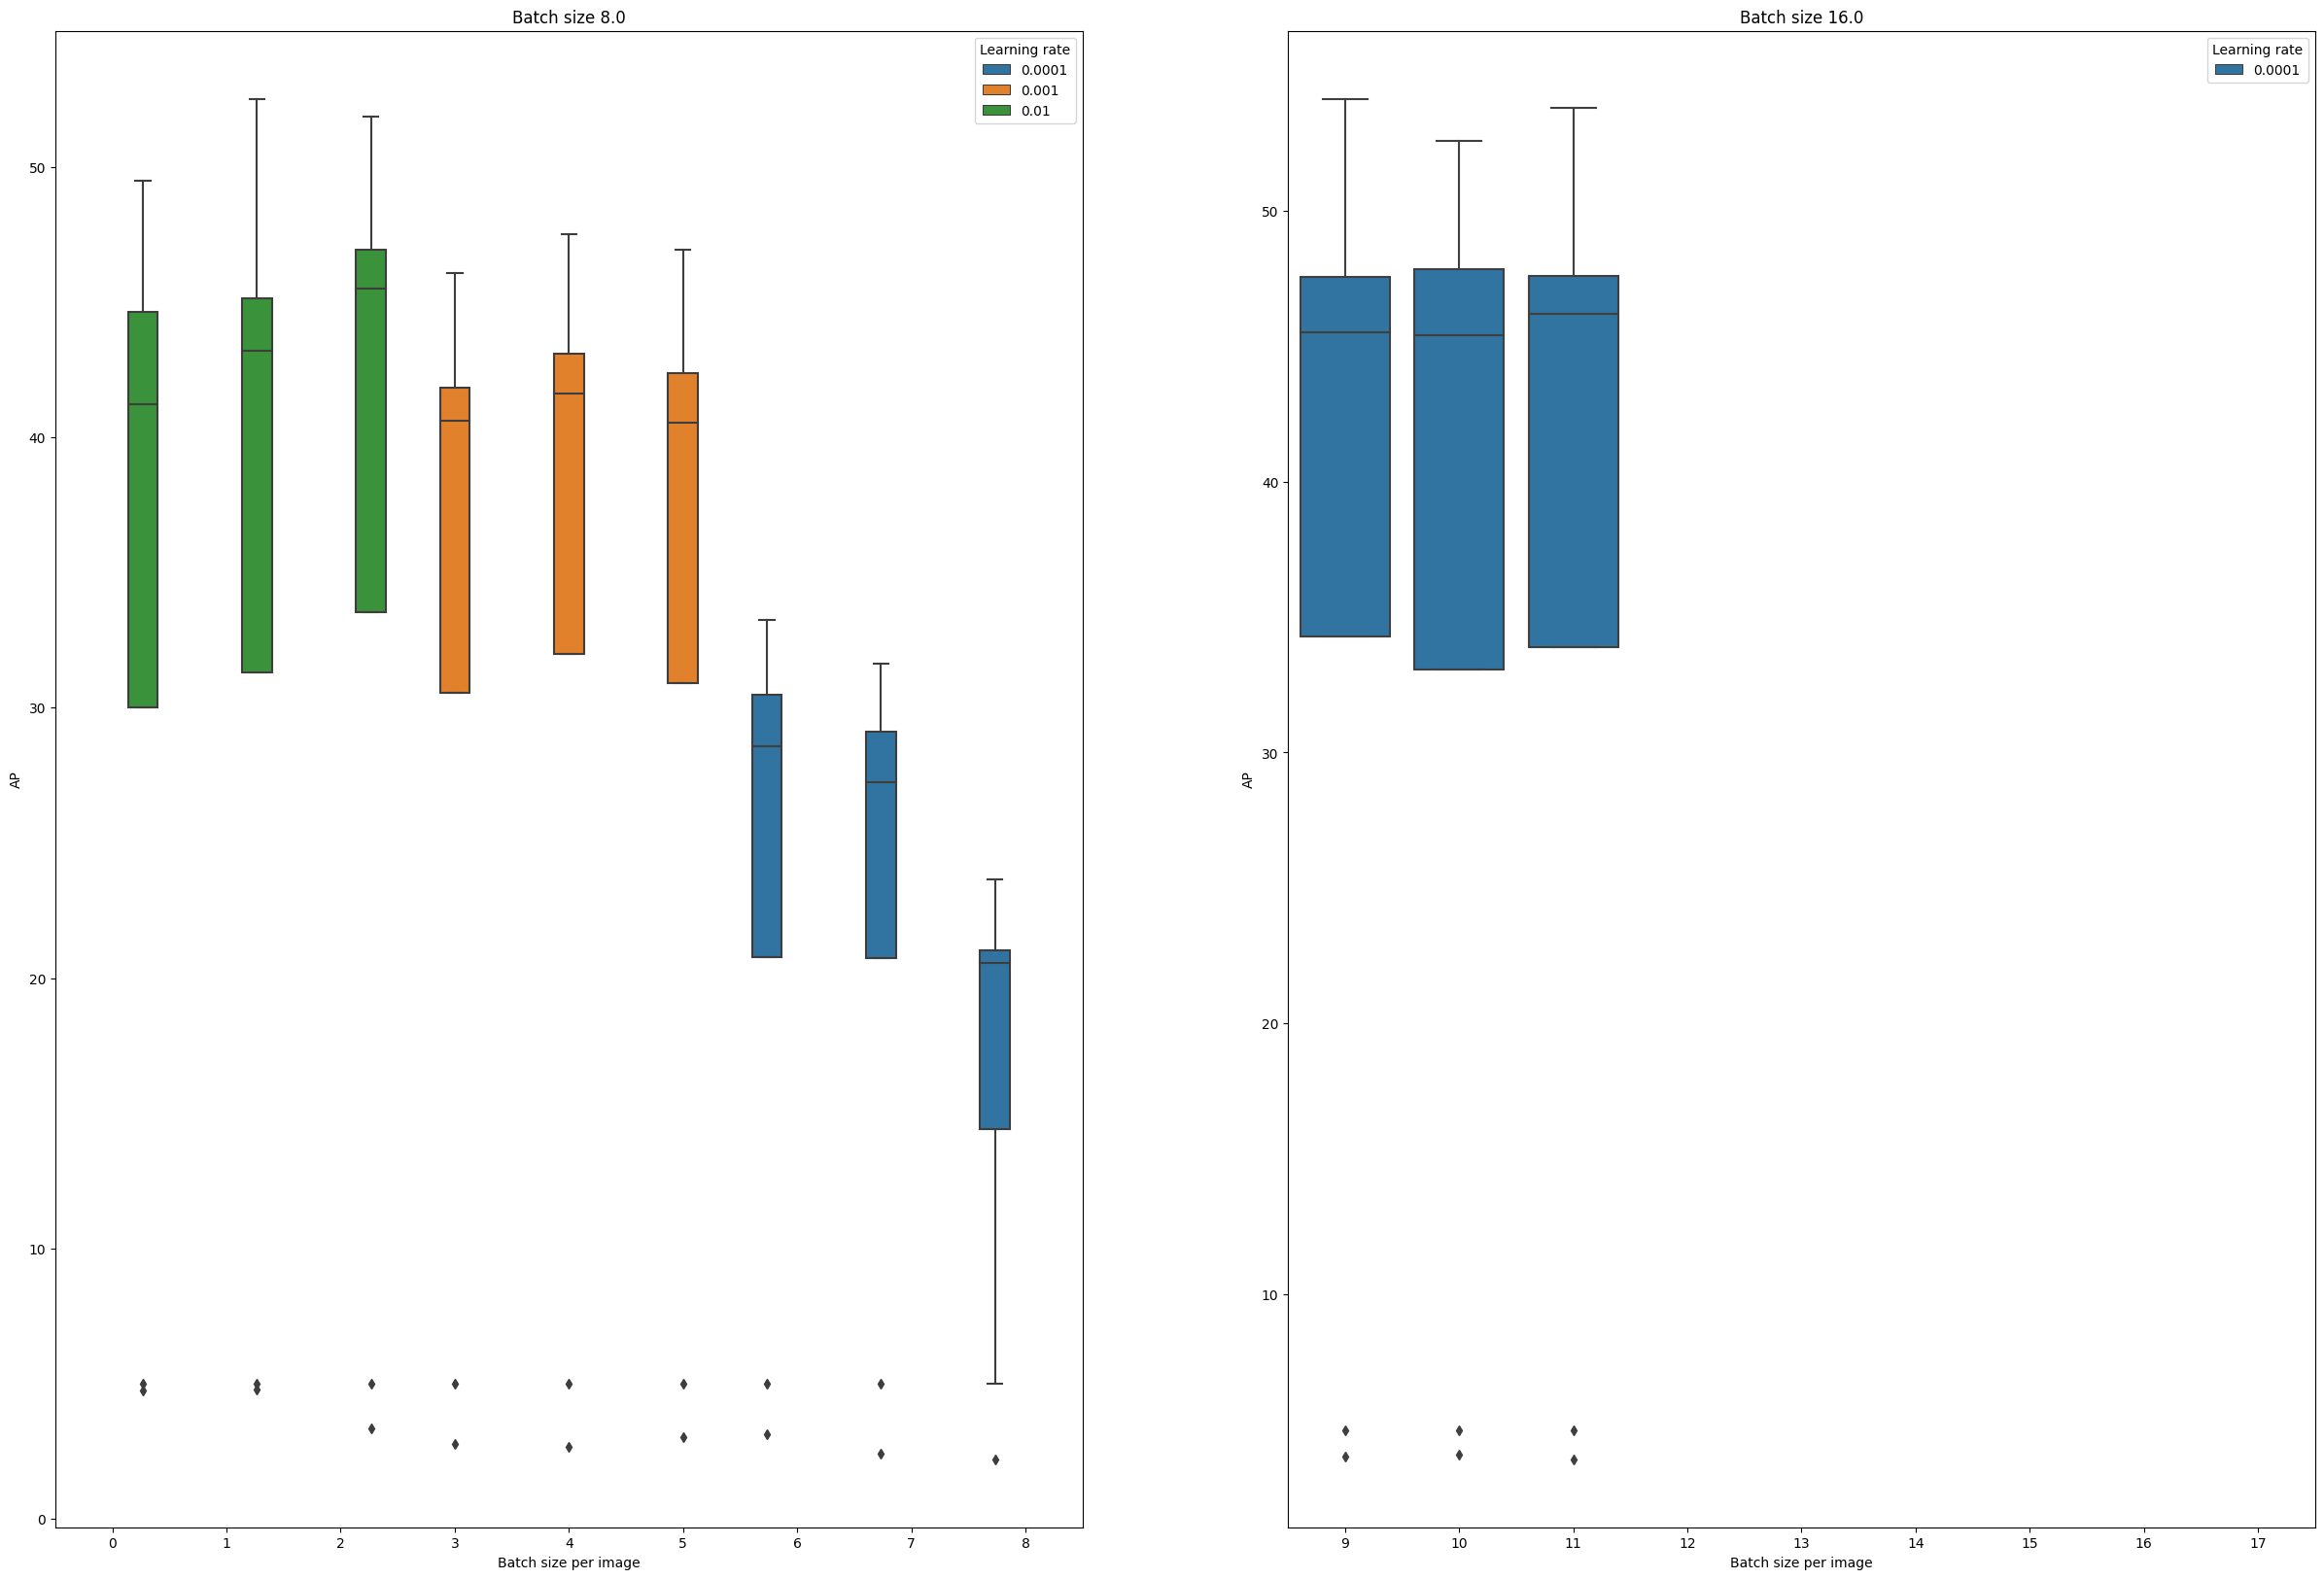

In [17]:
x_value = [128, 256, 512] * 2
x_values_df = pd.DataFrame(x_value, columns=['Batch size per image'])

hue_labels = [0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.0001, 0.0001, 0.0001]

fig, ax = plt.subplots(1, 2, figsize=(30, 20))

melt_bbox_0_11 = grouped_bbox_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_0_11['Learning rate'] = melt_bbox_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_0_11, hue='Learning rate', ax=ax[0])
#ax[0].set_xticklabels(x_values_df['Batch size per image'])
ax[0].set_xlabel('Batch size per image')
ax[0].set_ylabel('AP')
ax[0].set_title('Batch size 8.0')

melt_bbox_12_23 = grouped_bbox_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_12_23['Learning rate'] = melt_bbox_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=3)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_12_23, hue='Learning rate', ax=ax[1])
ax[1].set_title('Batch size 16.0')
#ax[1].set_xticklabels(x_values_df['Batch size per image'])
ax[1].set_xlabel('Batch size per image')
ax[1].set_ylabel('AP')

plt.show()


In [18]:
grouped_segm_data_0_11 = grouped_data_segm_df[0:9]
grouped_segm_data_12_23 = grouped_data_segm_df[9:18]
print(grouped_segm_data_0_11.shape, grouped_segm_data_12_23.shape)
grouped_segm_data_0_11.head()

(9, 8) (9, 8)


segm_AP_AP                                                        \
              count       mean       std        min        25%        50%   
OuterKey                                                                    
0               5.0  15.390359  2.872120  11.233704  14.291103  15.268353   
1               5.0  15.829881  1.622071  13.105083  15.677423  16.337149   
2               5.0  18.142083  3.444697  12.351533  18.281875  19.029283   
3               5.0  14.897699  2.224738  12.576405  13.176797  14.598387   
4               5.0  14.455119  1.700389  12.231576  13.336069  14.588213   

                                
                75%        max  
OuterKey                        
0         17.948424  18.210212  
1         16.940869  17.088879  
2         19.580239  21.467487  
3         16.085088  18.051816  
4         15.743075  16.376664

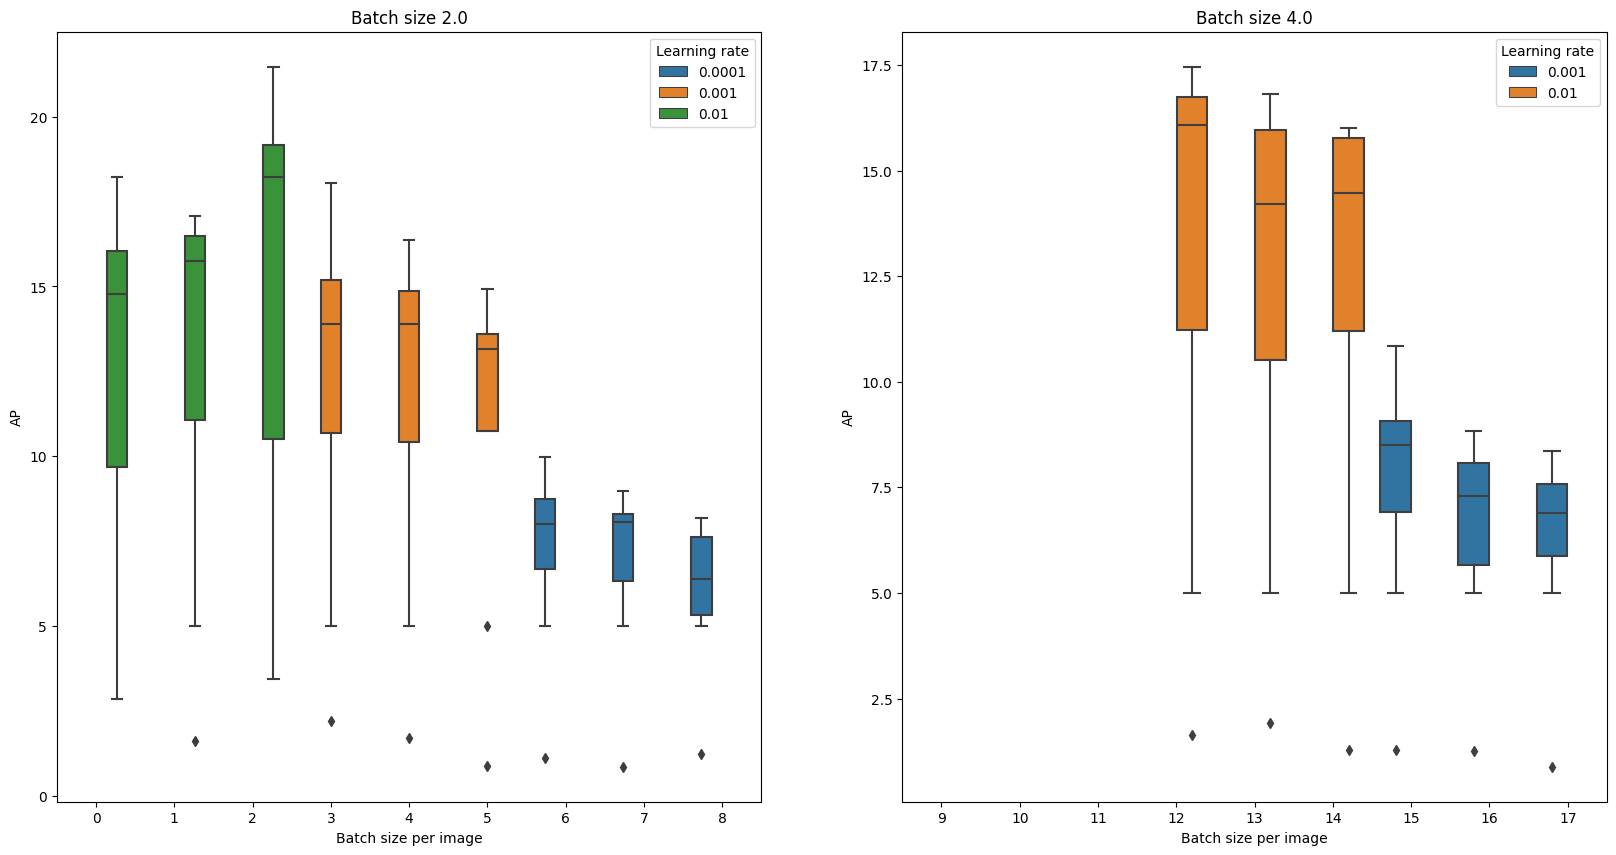

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

melt_segm_0_11 = grouped_segm_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_0_11['Learning rate'] = melt_segm_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_0_11, hue='Learning rate', ax=ax[0])
ax[0].set_xlabel('Batch size per image')
ax[0].set_ylabel('AP')
ax[0].set_title('Batch size 2.0')

melt_segm_12_23 = grouped_segm_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_12_23['Learning rate'] = melt_segm_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=12)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_12_23, hue='Learning rate', ax=ax[1])
ax[1].set_title('Batch size 4.0')
ax[1].set_xlabel('Batch size per image')
ax[1].set_ylabel('AP')

plt.show()


From the following graphs, we can extract that, as the performance increases, the variance of the results also increases. This is expected in neural networls as they are a high variance model.

# Metrics

In [20]:
best_model = "bs_16_lr_0.01_bsi_512"
best_model_0 = convert_tb_data(f"./../models/Glass_models/{best_model}/0")
best_model_1 = convert_tb_data(f"./../models/Glass_models/{best_model}/1")
best_model_2 = convert_tb_data(f"./../models/Glass_models/{best_model}/2")
best_model_3 = convert_tb_data(f"./../models/Glass_models/{best_model}/3")
best_model_4 = convert_tb_data(f"./../models/Glass_models/{best_model}/4")
best_model_0.head()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


,wall_time,name,step,value
0,1.732547e+09,data_time,18,0.389188
1,1.732547e+09,rpn/num_pos_anchors,19,8.468750
2,1.732547e+09,rpn/num_neg_anchors,19,247.531250
3,1.732547e+09,roi_head/num_fg_samples,19,7.843750
4,1.732547e+09,roi_head/num_bg_samples,19,504.156250


In [21]:
secondbest_model = "bs_16_lr_0.01_bsi_128"

secondbest_model_0 = convert_tb_data(f"./../models/Glass_models/{secondbest_model}/0")
secondbest_model_1 = convert_tb_data(f"./../models/Glass_models/{secondbest_model}/1")
secondbest_model_2 = convert_tb_data(f"./../models/Glass_models/{secondbest_model}/2")
secondbest_model_3 = convert_tb_data(f"./../models/Glass_models/{secondbest_model}/3")
secondbest_model_4 = convert_tb_data(f"./../models/Glass_models/{secondbest_model}/4")
secondbest_model_0.head()

,wall_time,name,step,value
0,1.732166e+09,data_time,18,0.402425
1,1.732166e+09,rpn/num_pos_anchors,19,7.593750
2,1.732166e+09,rpn/num_neg_anchors,19,248.406250
3,1.732166e+09,roi_head/num_fg_samples,19,8.000000
4,1.732166e+09,roi_head/num_bg_samples,19,120.000000


In [22]:
thirdbest_model = "bs_16_lr_0.01_bsi_1024"

thirdbest_model_0 = convert_tb_data(f"./../models/Glass_models/{thirdbest_model}/0")
thirdbest_model_1 = convert_tb_data(f"./../models/Glass_models/{thirdbest_model}/1")
thirdbest_model_2 = convert_tb_data(f"./../models/Glass_models/{thirdbest_model}/2")
thirdbest_model_3 = convert_tb_data(f"./../models/Glass_models/{thirdbest_model}/3")
thirdbest_model_4 = convert_tb_data(f"./../models/Glass_models/{thirdbest_model}/4")



In [23]:
best_model_0_metrics = best_model_0.pivot(index='step', columns='name', values='value')
best_model_0_metrics = best_model_0_metrics.dropna(how='all')
best_model_0_metrics_eval = best_model_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

best_model_1_metrics = best_model_1.pivot(index='step', columns='name', values='value')
best_model_1_metrics = best_model_1_metrics.dropna(how='all')
best_model_1_metrics_eval = best_model_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

best_model_2_metrics = best_model_2.pivot(index='step', columns='name', values='value')
best_model_2_metrics = best_model_2_metrics.dropna(how='all')
best_model_2_metrics_eval = best_model_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

best_model_3_metrics = best_model_3.pivot(index='step', columns='name', values='value')
best_model_3_metrics = best_model_3_metrics.dropna(how='all')
best_model_3_metrics_eval = best_model_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

best_model_4_metrics = best_model_4.pivot(index='step', columns='name', values='value')
best_model_4_metrics = best_model_4_metrics.dropna(how='all')
best_model_4_metrics_eval = best_model_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

In [24]:
secondbest_model_0_metrics = secondbest_model_0.pivot(index='step', columns='name', values='value')
secondbest_model_0_metrics = secondbest_model_0_metrics.dropna(how='all')
secondbest_model_0_metrics_eval = secondbest_model_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

secondbest_model_1_metrics = secondbest_model_1.pivot(index='step', columns='name', values='value')
secondbest_model_1_metrics = secondbest_model_1_metrics.dropna(how='all')
secondbest_model_1_metrics_eval = secondbest_model_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

secondbest_model_2_metrics = secondbest_model_2.pivot(index='step', columns='name', values='value')
secondbest_model_2_metrics = secondbest_model_2_metrics.dropna(how='all')
secondbest_model_2_metrics_eval = secondbest_model_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

secondbest_model_3_metrics = secondbest_model_3.pivot(index='step', columns='name', values='value')
secondbest_model_3_metrics = secondbest_model_3_metrics.dropna(how='all')
secondbest_model_3_metrics_eval = secondbest_model_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

secondbest_model_4_metrics = secondbest_model_4.pivot(index='step', columns='name', values='value')
secondbest_model_4_metrics = secondbest_model_4_metrics.dropna(how='all')
secondbest_model_4_metrics_eval = secondbest_model_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

secondbest_model_0_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,8.604490,21.020956,4.482526,10.523778,11.306005,10.693089,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,13.907793,29.702898,10.779886,19.800846,17.350203,13.755228,NaN,4023.988525,0.921143,0.186579,...,247.84375,8.15625,2.146997,7.436565,0.276994,0.000000,9.339679,1.436783,2.960817,0.771643
149,19.211096,38.384842,17.077248,29.077913,23.394400,16.817368,NaN,NaN,NaN,NaN,...,NaN,NaN,4.293995,14.873130,0.553988,0.000000,18.679358,2.873566,NaN,NaN
199,21.209143,38.969498,21.434479,35.457432,26.978516,18.167845,NaN,3904.534912,0.945801,0.104233,...,248.84375,7.15625,5.434616,18.183359,1.000883,0.631188,23.847754,3.770204,3.210410,0.459791
249,23.207190,39.554157,25.791712,41.836948,30.562632,19.518322,NaN,NaN,NaN,NaN,...,NaN,NaN,6.575237,21.493589,1.447779,1.262376,29.016151,4.666841,NaN,NaN


In [25]:
thirdbest_model_0_metrics = thirdbest_model_0.pivot(index='step', columns='name', values='value')
thirdbest_model_0_metrics = thirdbest_model_0_metrics.dropna(how='all')
thirdbest_model_0_metrics_eval = thirdbest_model_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

thirdbest_model_1_metrics = thirdbest_model_1.pivot(index='step', columns='name', values='value')
thirdbest_model_1_metrics = thirdbest_model_1_metrics.dropna(how='all')
thirdbest_model_1_metrics_eval = thirdbest_model_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

thirdbest_model_2_metrics = thirdbest_model_2.pivot(index='step', columns='name', values='value')
thirdbest_model_2_metrics = thirdbest_model_2_metrics.dropna(how='all')
thirdbest_model_2_metrics_eval = thirdbest_model_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

thirdbest_model_3_metrics = thirdbest_model_3.pivot(index='step', columns='name', values='value')
thirdbest_model_3_metrics = thirdbest_model_3_metrics.dropna(how='all')
thirdbest_model_3_metrics_eval = thirdbest_model_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

thirdbest_model_4_metrics = thirdbest_model_4.pivot(index='step', columns='name', values='value')
thirdbest_model_4_metrics = thirdbest_model_4_metrics.dropna(how='all')
thirdbest_model_4_metrics_eval = thirdbest_model_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

thirdbest_model_0_metrics_eval.head()


name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,3.888335,7.004599,2.944950,2.529493,11.742909,1.749175,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,9.201912,17.219332,7.631811,11.337313,16.868280,6.699593,NaN,1414.152344,0.983143,1.000000,...,247.53125,8.46875,1.822200,6.119612,0.164719,0.000000,10.939975,0.741603,1.181947,0.323329
149,14.515490,27.434067,12.318671,19.420237,21.993650,11.650010,NaN,NaN,NaN,NaN,...,NaN,NaN,3.644400,12.239224,0.329439,0.000000,21.879950,1.483206,NaN,NaN
199,16.656668,31.337080,15.258805,19.782684,23.612799,14.594900,NaN,1625.283691,0.984393,0.705182,...,247.71875,8.28125,5.146601,15.916529,0.702076,0.693069,24.918224,2.439875,1.797019,0.249526
249,18.797846,35.240093,18.198940,20.145132,25.231947,17.539789,NaN,NaN,NaN,NaN,...,NaN,NaN,6.648801,19.593832,1.074714,1.386139,27.956497,3.396545,NaN,NaN


In [26]:
best_model_avg_metrics = (best_model_0_metrics_eval + best_model_1_metrics_eval + best_model_2_metrics_eval + best_model_3_metrics_eval + best_model_4_metrics_eval + secondbest_model_0_metrics_eval + secondbest_model_1_metrics_eval + secondbest_model_2_metrics_eval + secondbest_model_3_metrics_eval + secondbest_model_4_metrics_eval) / 10
best_model_avg_metrics_eval = best_model_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
best_model_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,8.670042,21.322435,4.850631,9.937965,14.097141,7.029294,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,13.878989,29.352104,10.612447,17.162323,19.760063,11.745545,NaN,2443.827185,0.945111,0.582632,...,247.24375,8.75625,2.098850,7.733032,0.250895,0.496658,8.843757,1.343525,1.769367,0.592424
149,19.087935,37.381774,16.374264,24.386680,25.422985,16.461797,NaN,NaN,NaN,NaN,...,NaN,NaN,4.197700,15.466063,0.501789,0.988366,17.687515,2.687050,NaN,NaN
199,21.998068,40.042646,20.916492,27.941885,29.358992,18.376877,NaN,2321.704321,0.962256,0.238401,...,247.76875,8.23125,5.918141,20.282381,0.877606,2.200280,22.498759,3.610884,1.875133,0.388650
249,24.908201,42.518291,25.458720,31.497090,33.294999,20.291957,NaN,NaN,NaN,NaN,...,NaN,NaN,7.591467,25.098699,1.147645,3.207551,27.054408,4.485557,NaN,NaN


In [27]:
secondbest_model_avg_metrics = (secondbest_model_0_metrics + secondbest_model_1_metrics + secondbest_model_2_metrics + secondbest_model_3_metrics + secondbest_model_4_metrics) / 5
secondbest_model_avg_metrics_eval = secondbest_model_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
secondbest_model_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,7.911942,23.269614,2.537601,11.318637,11.105354,7.637254,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,14.593754,32.252026,10.467816,19.004593,19.358645,13.030046,NaN,3332.984106,0.923145,0.205255,...,247.49375,8.50625,2.294132,8.337442,0.236122,0.659158,8.627626,1.535076,2.386570,0.763018
149,21.275567,41.234440,18.398030,26.690548,27.611937,18.422838,NaN,NaN,NaN,NaN,...,NaN,NaN,4.588263,16.674883,0.472245,1.308416,17.255252,3.070152,NaN,NaN
199,24.811927,43.403096,25.012753,31.381680,32.672759,20.828415,NaN,3178.252661,0.948193,0.088482,...,248.04375,7.95625,6.310462,21.446510,0.910414,2.480043,21.935895,4.154396,2.611891,0.474269
249,28.348286,45.201300,31.627475,36.072810,37.733582,23.233992,NaN,NaN,NaN,NaN,...,NaN,NaN,8.032660,26.218135,1.348584,3.496125,26.616537,5.238640,NaN,NaN


In [28]:
secondbest_model_avg_metrics.columns

Index(['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APl', 'bbox/APm', 'bbox/APs',
       'data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy',
       'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'loss_box_reg',
       'loss_cls', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr',
       'mask_rcnn/accuracy', 'mask_rcnn/false_negative',
       'mask_rcnn/false_positive', 'roi_head/num_bg_samples',
       'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors',
       'segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APl', 'segm/APm', 'segm/APs',
       'time', 'total_loss'],
      dtype='object', name='name')

In [29]:
thirdbest_model_avg_metrics = (thirdbest_model_0_metrics + thirdbest_model_1_metrics + thirdbest_model_2_metrics + thirdbest_model_3_metrics + thirdbest_model_4_metrics) / 5
thirdbest_model_avg_metrics_eval = thirdbest_model_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
thirdbest_model_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,5.477069,10.051068,5.122411,3.640853,13.243797,2.989517,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,10.306527,19.607975,9.168793,12.258925,18.070589,7.253204,NaN,3139.488623,0.982588,1.000000,...,247.7750,8.2250,1.785994,6.582919,0.231233,0.274257,9.290326,0.890784,2.330297,0.330454
149,15.135985,29.164883,13.215175,20.732019,22.897382,11.516890,NaN,NaN,NaN,NaN,...,NaN,NaN,3.571988,13.165839,0.462466,0.548515,18.580653,1.781568,NaN,NaN
199,17.617333,32.708472,16.335170,23.146164,24.861071,14.113578,NaN,2976.404150,0.984530,0.754069,...,247.6125,8.3875,5.339506,17.982615,0.816642,1.877475,23.377370,2.549785,2.446759,0.257753
249,20.098679,36.252061,19.455166,25.560309,26.824761,16.710266,NaN,NaN,NaN,NaN,...,NaN,NaN,7.107023,22.799390,1.170819,3.206436,28.174087,3.318003,NaN,NaN


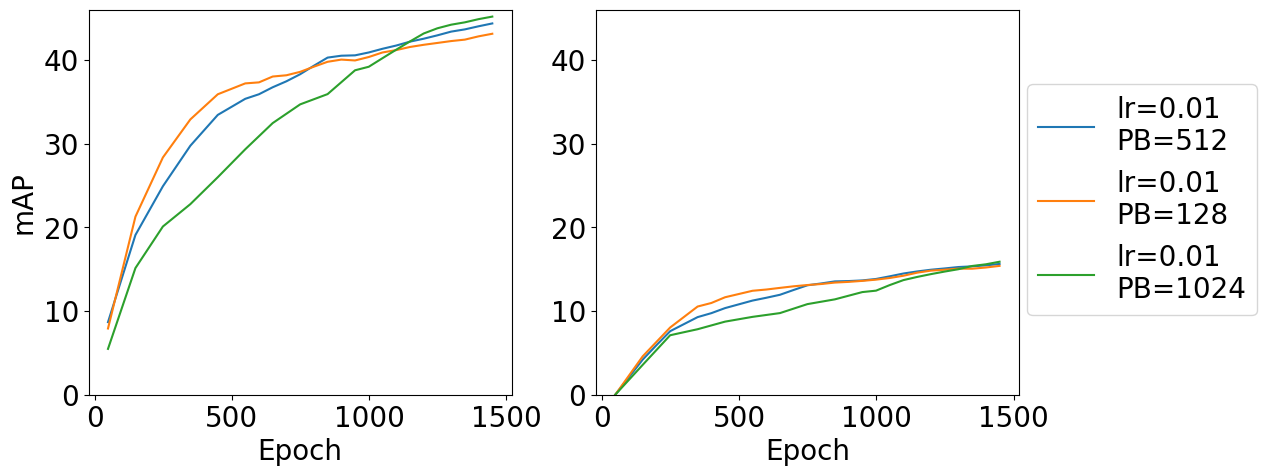

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot bounding box mAP
best_model_avg_metrics_eval.plot(
    y='bbox/AP', ax=ax[0], label='Learning rate=0.01, Proposed boxes=512'
)
secondbest_model_avg_metrics_eval.plot(
    y='bbox/AP', ax=ax[0], label='Learning rate=0.01, Proposed boxes=128'
)
thirdbest_model_avg_metrics_eval.plot(
    y='bbox/AP', ax=ax[0], label='Learning rate=0.01, Proposed boxes=1024'
)

# Plot segmentation mAP
best_model_avg_metrics_eval.plot(
    y='segm/AP', ax=ax[1], label='Learning rate=0.01, Proposed boxes=512'
)
secondbest_model_avg_metrics_eval.plot(
    y='segm/AP', ax=ax[1], label='Learning rate=0.01, Proposed boxes=128'
)
thirdbest_model_avg_metrics_eval.plot(
    y='segm/AP', ax=ax[1], label='Learning rate=0.01, Proposed boxes=1024'
)

# Set labels and limits for the first subplot
ax[0].set_xlabel('Epoch', fontsize=20)
ax[0].set_ylabel('mAP', fontsize=20)
ax[0].set_ylim(0, 46)
ax[0].tick_params(axis='y', which='major', labelsize=20)
ax[0].tick_params(axis='x', which='major', labelsize=20)

# Set labels and limits for the second subplot
ax[1].set_xlabel('Epoch', fontsize=20)
ax[1].set_ylim(0, 46)
ax[1].tick_params(axis='y', which='major', labelsize=20)
ax[1].tick_params(axis='x', which='major', labelsize=20)

# Combine legends from both plots
lines, labels = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()
ax[1].get_legend().remove()
fig.legend(
    lines,
    ['lr=0.01\nPB=512', 'lr=0.01\nPB=128', 'lr=0.01\nPB=1024'],
    loc='right',
    fontsize=20,
    bbox_to_anchor=(1.11, 0.5),
)

plt.savefig("../../plots/glass_comparing_final_models.png", dpi=300, bbox_inches='tight')
plt.show()

Comparing both models when trained up to 5000 epochs, we can observe that in both cases model 38 is the best performing. 

## Overfitting

In [31]:
best_model_avg_metrics_eval = best_model_avg_metrics_eval.drop(columns=['data_time'])
best_model_avg_metrics_eval = best_model_avg_metrics_eval.dropna()
print(best_model_avg_metrics_eval.head())

name    bbox/AP  bbox/AP50  bbox/AP75   bbox/APl   bbox/APm   bbox/APs  \
step                                                                     
99    13.878989  29.352104  10.612447  17.162323  19.760063  11.745545   
199   21.998068  40.042646  20.916492  27.941885  29.358992  18.376877   
299   27.328451  44.702127  29.140759  34.528312  35.894660  22.158580   
399   31.591334  48.429161  35.337659  39.802788  40.720367  25.051840   
499   34.394180  51.796283  38.853405  43.382938  44.242657  27.371018   

name  eta_seconds  fast_rcnn/cls_accuracy  fast_rcnn/false_negative  \
step                                                                  
99    2443.827185                0.945111                  0.582632   
199   2321.704321                0.962256                  0.238401   
299   2173.043787                0.970587                  0.178422   
399   2012.328204                0.975085                  0.138880   
499   1834.319403                0.977625              

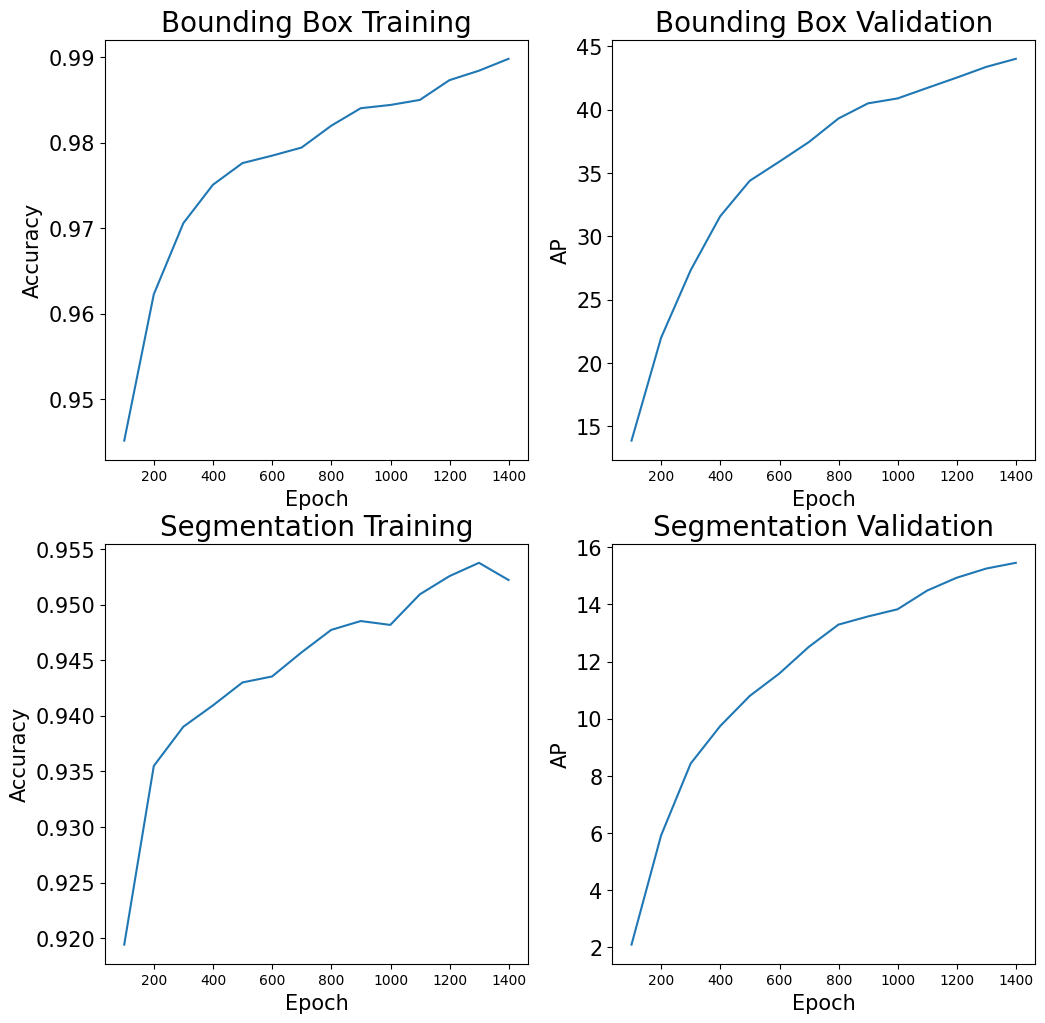

In [32]:
# Plot the curve of the average of model 50 that compares bbox/AP to fast_rcnn/cls_accuracy and segm/AP to mask_rcnn/accuracy, set log scale on the y-axis
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

best_model_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0][1], legend=False)
best_model_avg_metrics_eval.plot(y='fast_rcnn/cls_accuracy', ax=ax[0][0], legend=False)

best_model_avg_metrics_eval.plot(y='segm/AP', ax=ax[1][1], legend=False)
best_model_avg_metrics_eval.plot(y='mask_rcnn/accuracy', ax=ax[1][0], legend=False)

#ax[0][1].legend(fontsize=20)
ax[0][0].set_title('Bounding Box Training', fontsize=20)
ax[0][0].set_xlabel('Epoch', fontsize=15)
ax[0][0].set_ylabel('Accuracy', fontsize=15)
ax[0][0].tick_params(axis='y', which='both', labelsize=15)

#ax[0][0].legend(fontsize=20)
ax[0][1].set_title('Bounding Box Validation', fontsize=20)
ax[0][1].set_xlabel('Epoch', fontsize=15)
ax[0][1].set_ylabel('AP', fontsize=15)
ax[0][1].tick_params(axis='y', which='both', labelsize=15)

#ax[1][1].legend(fontsize=20)
ax[1][0].set_title('Segmentation Training', fontsize=20)
ax[1][0].set_xlabel('Epoch', fontsize=15)
ax[1][0].set_ylabel('Accuracy', fontsize=15)
ax[1][0].tick_params(axis='y', which='both', labelsize=15)

#ax[1][0].legend(fontsize=20)
ax[1][1].set_title('Segmentation Validation', fontsize=20)
ax[1][1].set_xlabel('Epoch', fontsize=15)
ax[1][1].set_ylabel('AP', fontsize=15)
ax[1][1].tick_params(axis='y', which='both', labelsize=15)

plt.show()

From comparing training and evaluation curves, we can clearly see that around epoch 3000 the model starts overfitting as the training loss keeps decreasing while the evaluation loss starts increasing. This means that the final model should be trained up to 3000 epochs.

In [33]:

final_model = best_model_avg_metrics_eval.iloc[-1]
final_model

name
bbox/AP                       44.021197
bbox/AP50                     65.971158
bbox/AP75                     50.559827
bbox/APl                      53.136296
bbox/APm                      54.892376
bbox/APs                      36.021235
eta_seconds                  170.172642
fast_rcnn/cls_accuracy         0.989838
fast_rcnn/false_negative       0.053279
fast_rcnn/fg_cls_accuracy      0.937508
loss_box_reg                   0.085177
loss_cls                       0.026919
loss_mask                      0.108978
loss_rpn_cls                   0.001104
loss_rpn_loc                   0.006931
lr                             0.010000
mask_rcnn/accuracy             0.952217
mask_rcnn/false_negative       0.144958
mask_rcnn/false_positive       0.027179
roi_head/num_bg_samples      298.634375
roi_head/num_fg_samples       21.365625
rpn/num_neg_anchors          248.068750
rpn/num_pos_anchors            7.931250
segm/AP                       15.456077
segm/AP50                     46.91

# Final model

For our final model we will use the following hyperparameters: bs=8.0, lr=0.001, bspi=256 and 3000 epochs traiend on all data.

In [34]:
final_0 = convert_tb_data("./../models/Glass_final_model/0")
final_1 = convert_tb_data("./../models/Glass_final_model/1")
final_2 = convert_tb_data("./../models/Glass_final_model/2")
final_3 = convert_tb_data("./../models/Glass_final_model/3")
final_4 = convert_tb_data("./../models/Glass_final_model/4")

final_0.head()

,wall_time,name,step,value
0,1.734081e+09,data_time,18,0.434373
1,1.734081e+09,rpn/num_pos_anchors,19,7.843750
2,1.734081e+09,rpn/num_neg_anchors,19,248.156250
3,1.734081e+09,roi_head/num_fg_samples,19,8.093750
4,1.734081e+09,roi_head/num_bg_samples,19,993.093750


In [35]:
final_0 = final_0.pivot(index='step', columns='name', values='value')
final_0 = final_0.drop(columns=['data_time'])
final_0 = final_0.dropna(axis=0, how='any')

final_1 = final_1.pivot(index='step', columns='name', values='value')
final_1 = final_1.drop(columns=['data_time'])
final_1 = final_1.dropna(axis=0, how='any')

final_2 = final_2.pivot(index='step', columns='name', values='value')
final_2 = final_2.drop(columns=['data_time'])
final_2 = final_2.dropna(axis=0, how='any')

final_3 = final_3.pivot(index='step', columns='name', values='value')
final_3 = final_3.drop(columns=['data_time'])
final_3 = final_3.dropna(axis=0, how='any')

final_4 = final_4.pivot(index='step', columns='name', values='value')
final_4 = final_4.drop(columns=['data_time'])
final_4 = final_4.dropna(axis=0, how='any')

final_0.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,9.285892,17.827099,7.347597,10.374398,16.188040,7.641552,2836.650391,0.982270,1.000000,0.000000,...,248.21875,7.78125,1.958168,6.453394,0.135827,0.000000,10.695057,0.848827,1.023262,0.322960
199,16.873741,31.546818,14.092980,19.795624,22.975122,16.325014,2838.663330,0.984424,0.713440,0.186498,...,248.03125,7.96875,5.136938,15.882140,0.785353,0.519802,24.122299,2.696780,1.035180,0.253670
299,20.086550,36.737286,17.373989,22.345814,26.073660,19.701139,2761.080078,0.984893,0.454858,0.367819,...,247.90625,8.09375,6.536223,20.476070,1.124151,2.128713,26.915997,3.686709,1.084242,0.222286
399,22.812563,40.118481,21.209637,24.890921,29.539814,21.351213,2674.644043,0.986019,0.435668,0.398182,...,247.15625,8.84375,7.079622,22.849356,1.269407,3.044554,26.915997,3.814024,1.091588,0.224923
499,26.185080,42.955803,26.178514,30.287880,34.328869,22.684584,2603.068115,0.988482,0.321397,0.494949,...,248.31250,7.68750,7.536395,25.297501,1.398352,3.539604,28.030949,3.976856,1.084773,0.188452


In [36]:
final_avg = (final_0 + final_1 + final_2 + final_3 + final_4) / 5
final_avg = final_avg.dropna(subset=['bbox/AP', 'segm/AP'])
final_avg.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,10.826914,19.435471,10.321924,13.745024,18.643040,7.175559,3069.615332,0.982744,1.000000,0.000000,...,247.67500,8.32500,1.697818,6.158277,0.191572,0.354455,8.997893,0.816572,1.103119,0.322285
199,18.170487,32.162623,17.635025,24.381617,25.483327,14.732353,2989.631982,0.985067,0.744234,0.147877,...,247.54375,8.45625,5.063061,17.383446,0.722321,1.985278,22.729853,2.432156,1.078422,0.262271
299,22.081721,38.062721,22.254977,27.855539,28.936216,18.667133,2888.803516,0.986272,0.476684,0.335293,...,247.68125,8.31875,7.142870,23.603799,1.090261,3.750872,27.376817,3.624780,1.086775,0.223867
399,25.316250,41.811331,26.939018,31.074501,32.350869,21.514013,2794.449512,0.986872,0.405785,0.389511,...,247.85625,8.14375,7.923993,26.047160,1.312226,4.303578,27.961372,4.258810,1.124578,0.211549
499,28.410069,44.348883,31.865983,35.187807,36.399122,23.688691,2697.467725,0.988326,0.343070,0.477998,...,247.59375,8.40625,8.481302,28.226234,1.451113,4.958033,29.090440,4.659566,1.101474,0.195530


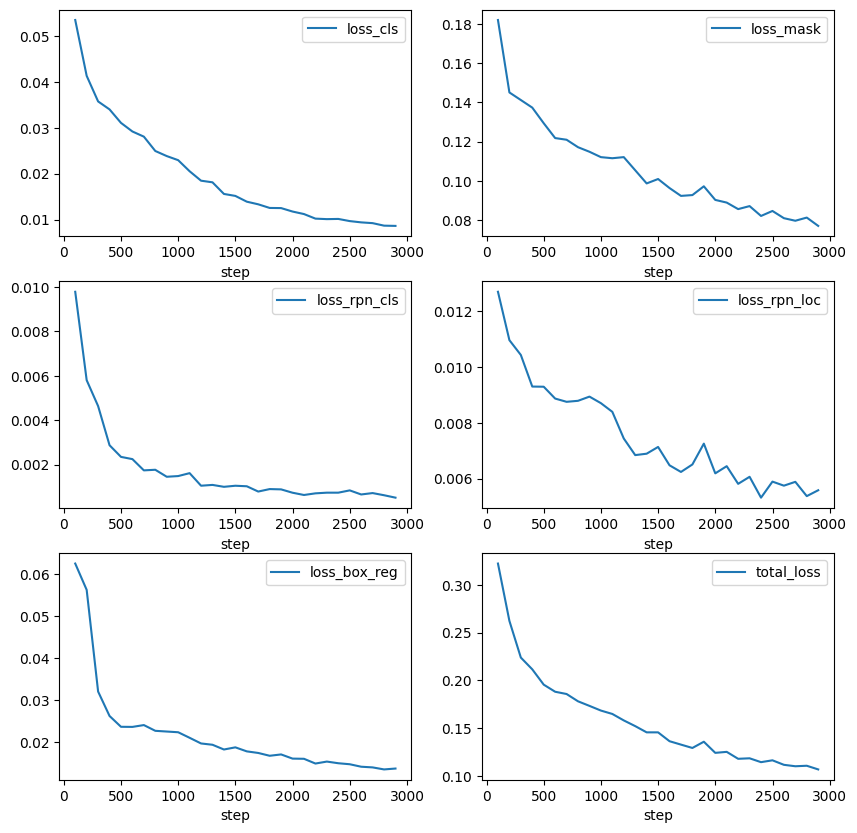

In [37]:
fig, ax = plt.subplots(3,2, figsize=(10, 10))

final_avg.plot(y='loss_cls', ax=ax[0][0], label='loss_cls')
final_avg.plot(y='loss_mask', ax=ax[0][1], label='loss_mask')
final_avg.plot(y='loss_rpn_cls', ax=ax[1][0], label='loss_rpn_cls')
final_avg.plot(y='loss_rpn_loc', ax=ax[1][1], label='loss_rpn_loc')
final_avg.plot(y='loss_box_reg', ax=ax[2][0], label='loss_box_reg')
final_avg.plot(y='total_loss', ax=ax[2][1], label='total_loss')

plt.show()

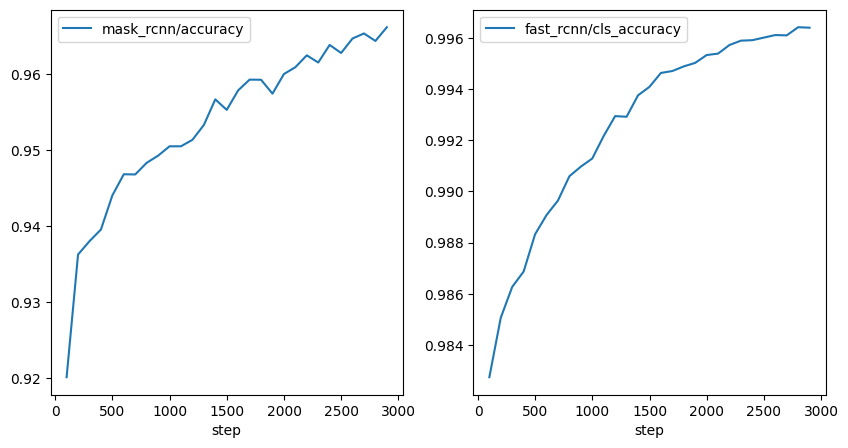

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

final_avg.plot(y='mask_rcnn/accuracy', ax=ax[0], label='mask_rcnn/accuracy')
final_avg.plot(y='fast_rcnn/cls_accuracy', ax=ax[1], label='fast_rcnn/cls_accuracy')

plt.show()

In [39]:
final_avg.iloc[-1]

name
bbox/AP                       48.019794
bbox/AP50                     68.911876
bbox/AP75                     54.938036
bbox/APl                      55.365644
bbox/APm                      57.834860
bbox/APs                      40.067198
eta_seconds                  115.047734
fast_rcnn/cls_accuracy         0.996391
fast_rcnn/false_negative       0.085128
fast_rcnn/fg_cls_accuracy      0.912893
loss_box_reg                   0.013753
loss_cls                       0.008617
loss_mask                      0.077033
loss_rpn_cls                   0.000516
loss_rpn_loc                   0.005583
lr                             0.010000
mask_rcnn/accuracy             0.966209
mask_rcnn/false_negative       0.106164
mask_rcnn/false_positive       0.020247
roi_head/num_bg_samples      978.443750
roi_head/num_fg_samples       22.662500
rpn/num_neg_anchors          247.712500
rpn/num_pos_anchors            8.287500
segm/AP                       16.892758
segm/AP50                     50.25

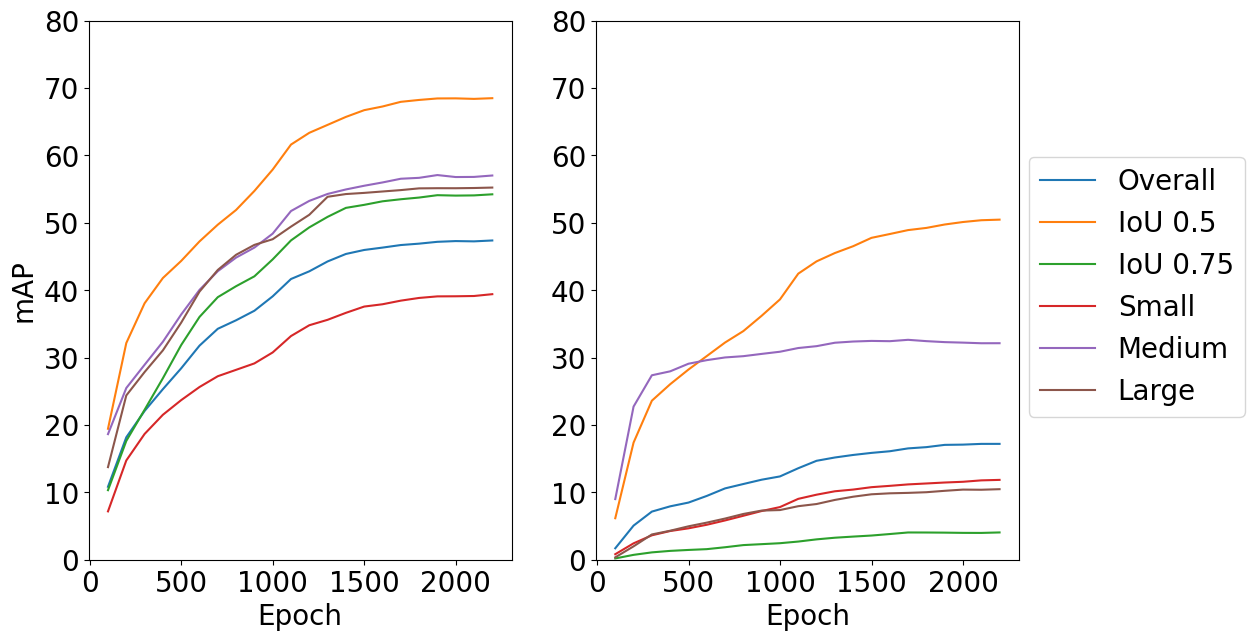

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

# Get final average until epoch 2000, this means that step is 2000
final_avg = final_avg[final_avg.index <= 2200]
bbox_lines = final_avg.plot(
    y=['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APs', 'bbox/APm', 'bbox/APl'], 
    ax=ax[0]
)
segm_lines = final_avg.plot(
    y=['segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APs', 'segm/APm', 'segm/APl'], 
    ax=ax[1]
)

# Set labels and limits for the first subplot
ax[0].set_xlabel('Epoch', fontsize=20)
ax[0].set_ylabel('mAP', fontsize=20)
ax[0].set_ylim(0, 80)
ax[0].tick_params(axis='y', which='major', labelsize=20)
ax[0].tick_params(axis='x', which='major', labelsize=20)

# Set labels and limits for the second subplot
ax[1].set_xlabel('Epoch', fontsize=20)
#ax[1].set_ylabel('mAP', fontsize=20)
ax[1].set_ylim(0, 80)
ax[1].tick_params(axis='y', which='major', labelsize=20)
ax[1].tick_params(axis='x', which='major', labelsize=20)

# Combine legends from both plots
lines, labels = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()
ax[1].get_legend().remove()
fig.legend(lines, ['Overall', 'IoU 0.5', 'IoU 0.75', 'Small', 'Medium', 'Large'], 
           loc='right', fontsize=20, bbox_to_anchor=(1.10, 0.5))

plt.savefig("../../plots/glass_final_model_of.png", dpi=300, bbox_inches='tight')
plt.show()

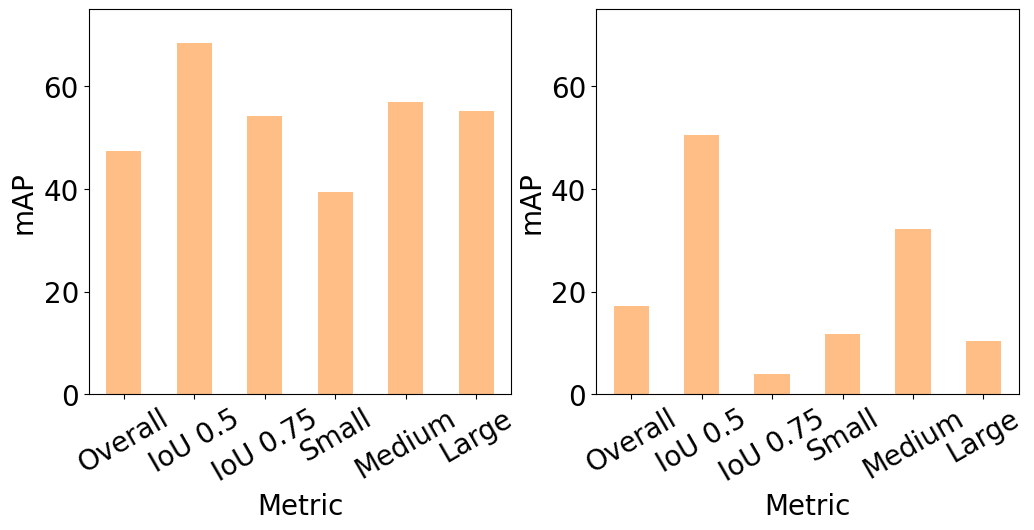

In [41]:
# Plot bar chart of the final model at the last epoch
final_avg_metrics_last_epoch = final_avg.iloc[-1]

fs = 20
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

bbox_metrics = ['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APs', 'bbox/APm', 'bbox/APl']
segm_metrics = ['segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APs', 'segm/APm', 'segm/APl']

# Plotting bbox metrics
final_avg_metrics_last_epoch[bbox_metrics].plot(kind='bar', ax=ax[0], alpha=0.5, label='Bounding Box', color='#ff7f0e', position=0.5)

# Plotting segm metrics
final_avg_metrics_last_epoch[segm_metrics].plot(kind='bar', ax=ax[1], alpha=0.5, label='Segmentation', color='#ff7f0e', position=0.5)

ax[0].set_ylim(0, 75)
ax[1].set_ylim(0, 75)

#ax[0].legend(fontsize=fs)
#ax[0].set_title('Bounding Box mAP', fontsize=30)
ax[0].set_ylabel('mAP', fontsize=fs)
ax[0].set_xlabel('Metric', fontsize=fs)
ax[0].set_xticklabels(['Overall', 'IoU 0.5', 'IoU 0.75', 'Small', 'Medium', 'Large'], rotation=30, fontsize=fs)
ax[0].tick_params(axis='y', labelsize=fs)

#ax[1].legend(fontsize=fs)
#ax[1].set_title('Segmentation mAP', fontsize=30)
ax[1].set_ylabel('mAP', fontsize=fs)
ax[1].set_xlabel('Metric', fontsize=fs)
ax[1].set_xticklabels(['Overall', 'IoU 0.5', 'IoU 0.75', 'Small', 'Medium', 'Large'], rotation=30, fontsize=fs)
ax[1].tick_params(axis='y', labelsize=fs)

plt.savefig("../../plots/glass_final_models_evals.png", dpi=300, bbox_inches='tight')
plt.show()

In [42]:
unet_segm_results = [10.11, 9.08, 8.42]

additional_data = {
    'Metric': ['Overall', 'IoU 0.5', 'IoU 0.75'],
    'unet_segm': unet_segm_results,
}
additional_df = pd.DataFrame(additional_data)

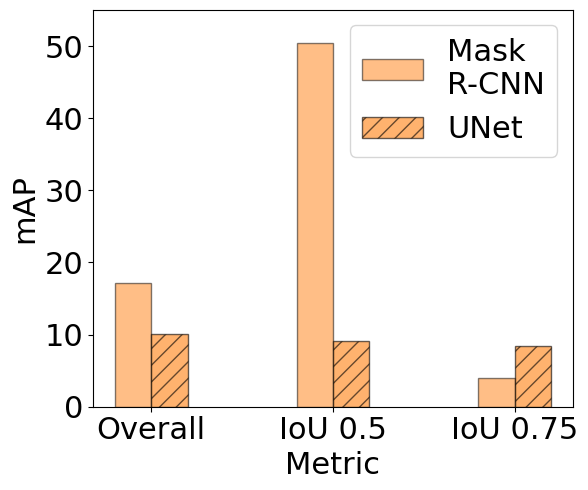

In [43]:
segm_metrics = ['segm/AP', 'segm/AP50', 'segm/AP75']

fs = 22
x_labels = ['Overall', 'IoU 0.5', 'IoU 0.75']
# Initialize the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Set bar width and positions
bar_width = 0.2
index = np.arange(len(x_labels))

# Plotting Final Model Metrics
ax.bar(index, final_avg_metrics_last_epoch[segm_metrics].values.flatten(), bar_width,
       alpha=0.5, label='Mask\nR-CNN', color='#ff7f0e', edgecolor='black')

# Plotting UNet Metrics
ax.bar(index + bar_width, unet_segm_results, bar_width,
       alpha=0.6, label='UNet', color='#ff7f0e', hatch='//', edgecolor='black')

# Customize the plot
#ax.set_title('Glass Dataset: mAP for Mask R-CNN vs UNet', fontsize=fs)
ax.set_ylabel('mAP', fontsize=fs)
ax.set_xlabel('Metric', fontsize=fs)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_labels, rotation=0, fontsize=fs)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fs)
ax.set_ylim(0, 55)
ax.legend(fontsize=fs)

# Show the plot
plt.tight_layout()
plt.savefig("../../plots/glass_dataset_baselines.png", dpi=300, bbox_inches='tight')
plt.show()
